In [1]:
from google.colab import drive
drive.mount('/content/drive/')
import os
if os.getcwd() != '/content/drive/My Drive':
    os.chdir('./drive/My Drive')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import numpy as np
import os
import tensorflow as tf

In [3]:
actions = ['OKAY', 'NO', 'COME', 'AWAY', 'STAY', 
           'GOOD', 'VICTORY', 'HELLO', 'PROMISE', 'ROCK']

data = np.concatenate([
    np.load('./DeeplearningProject/dataset/seq_Okay.npy'),
    np.load('./DeeplearningProject/dataset/seq_No.npy'),
    np.load('./DeeplearningProject/dataset/seq_Come.npy'),
    np.load('./DeeplearningProject/dataset/seq_Away.npy'),
    np.load('./DeeplearningProject/dataset/seq_Stay.npy'),
    np.load('./DeeplearningProject/dataset/seq_Good.npy'),
    np.load('./DeeplearningProject/dataset/seq_Victory.npy'),
    np.load('./DeeplearningProject/dataset/seq_Hello.npy'),
    np.load('./DeeplearningProject/dataset/seq_Promise.npy'),
    np.load('./DeeplearningProject/dataset/seq_ROCK.npy')
], axis=0)

print(data.shape)

(6317, 45, 100)


In [4]:
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(6317, 45, 99)
(6317,)


In [5]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))

print(y_data.shape)

(6317, 10)


In [6]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2023)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(5685, 45, 99) (5685, 10)
(632, 45, 99) (632, 10)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU,Dense, Dropout, Bidirectional

model = Sequential()
 
model.add(LSTM(64, input_shape=x_train.shape[1:3], return_sequences=True))
model.add(Bidirectional(LSTM(64, input_shape=x_train.shape[1:3], return_sequences=True)))
model.add(Bidirectional(LSTM(64, input_shape=x_train.shape[1:3], return_sequences=True)))
model.add(LSTM(64, input_shape=x_train.shape[1:3], return_sequences=False))

model.add(Dense(32))
model.add(Dense(len(actions), activation='softmax'))

model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 45, 64)            41984     
                                                                 
 bidirectional (Bidirectiona  (None, 45, 128)          66048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 45, 128)          98816     
 nal)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 10)                3

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    batch_size = 32,
    epochs=150,
    callbacks=[
        ModelCheckpoint('./DeeplearningProject/models/model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)

Epoch 1/150
178/178 [==============================] - ETA: 0s - loss: 0.1639 - acc: 0.9676
Epoch 1: val_acc improved from -inf to 1.00000, saving model to ./DeeplearningProject/models/model.h5
178/178 [==============================] - 26s 100ms/step - loss: 0.1639 - acc: 0.9676 - val_loss: 0.0080 - val_acc: 1.0000 - lr: 0.0010
Epoch 2/150
178/178 [==============================] - ETA: 0s - loss: 0.0022 - acc: 0.9998
Epoch 2: val_acc did not improve from 1.00000
178/178 [==============================] - 17s 94ms/step - loss: 0.0022 - acc: 0.9998 - val_loss: 9.3421e-04 - val_acc: 1.0000 - lr: 0.0010
Epoch 3/150
178/178 [==============================] - ETA: 0s - loss: 6.3131e-04 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
178/178 [==============================] - 16s 92ms/step - loss: 6.3131e-04 - acc: 1.0000 - val_loss: 4.1876e-04 - val_acc: 1.0000 - lr: 0.0010
Epoch 4/150
178/178 [==============================] - ETA: 0s - loss: 3.2336e-04 - acc: 1.0000
Epoch 4: 

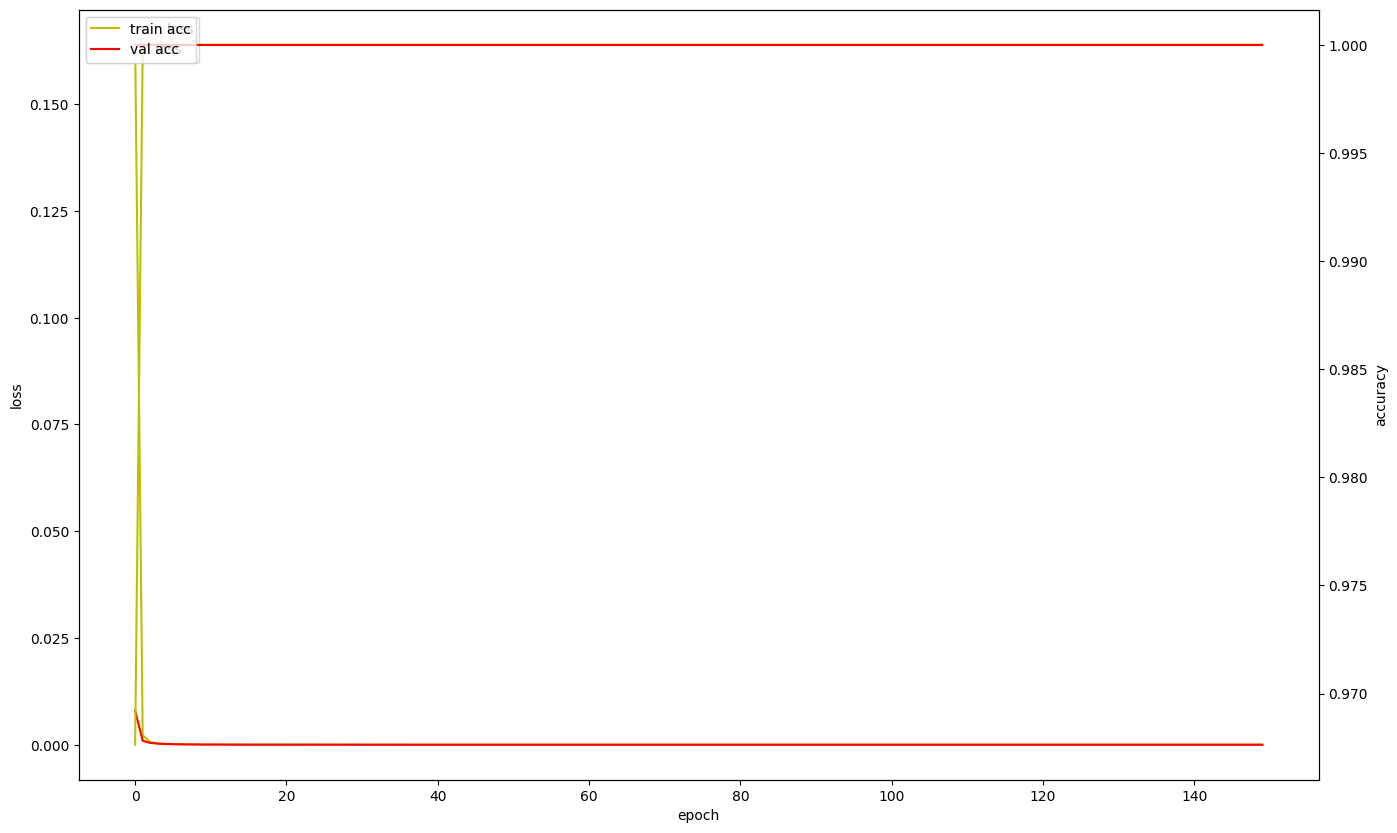

In [9]:
import matplotlib.pyplot as plt

flg, loss_ax = plt.subplots(figsize=(16,10))
acc_ax =loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'y', label='train acc')
acc_ax.plot(history.history['val_acc'], 'r', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [10]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

model = load_model('./DeeplearningProject/models/model.h5')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

20/20 [==============================] - 2s 30ms/step


array([[[583,   0],
        [  0,  49]],

       [[572,   0],
        [  0,  60]],

       [[565,   0],
        [  0,  67]],

       [[571,   0],
        [  0,  61]],

       [[558,   0],
        [  0,  74]],

       [[556,   0],
        [  0,  76]],

       [[571,   0],
        [  0,  61]],

       [[568,   0],
        [  0,  64]],

       [[569,   0],
        [  0,  63]],

       [[575,   0],
        [  0,  57]]])